In [32]:
import pymc3 as pm

## leapfrog integrator.

In [ ]:
def leapfrog(q0, p0, target, L, step_size):
    q = q0.copy()
    p = p0.copy()

    for i in range(L):
        p += target.grad_log_density(q) * step_size / 2
        q += p * step_size
        p += target.grad_log_density(q) * step_size / 2

    return q, p

## implementation of Hamiltonian Monte Carlo

In [26]:
def hmc(target, initial, iterations=10_000, L=50, step_size=0.1):
    samples = [initial()]

    for i in range(iterations):
        q0 = samples[-1]
        p0 = np.random.standard_normal(size=q0.size)

        q_star, p_star = leapfrog(q0, p0, target, L, step_size)

        h0 = -target.log_density(q0) + (p0 * p0).sum() / 2
        h = -target.log_density(q_star) + (p_star * p_star).sum() / 2
        log_accept_ratio = h0 - h

        if np.random.random() < np.exp(log_accept_ratio):
            samples.append(q_star)
        else:
            samples.append(q0)

    return samples

## donut target density

In [27]:
class DonutPDF:
    def __init__(self, radius=3, sigma2=0.05):
        self.radius = radius
        self.sigma2 = sigma2

    def log_density(self, x):
        r = np.linalg.norm(x)
        return -((r - self.radius) ** 2) / self.sigma2

    def grad_log_density(self, x):
        r = np.linalg.norm(x)
        if r == 0:
            return np.zeros_like(x)
        return 2 * x * (self.radius / r - 1) / self.sigma2

## Draw samples with HMC

In [28]:
hmc_samples = hmc(DonutPDF(), lambda: np.array([3, 0.0]));

In [29]:
print(hmc_samples)

[array([3., 0.]), array([2.89991509, 0.78660577]), array([2.89991509, 0.78660577]), array([2.72547313, 1.12661906]), array([2.72547313, 1.12661906]), array([ 2.04392092, -2.28326774]), array([2.65869601, 1.47350838]), array([2.30050769, 2.26585683]), array([-3.06146319,  0.18290518]), array([1.0721662, 2.7800669]), array([1.7632028 , 1.96215745]), array([0.13770353, 2.69560863]), array([2.58210689, 1.12742389]), array([2.94368706, 0.2259662 ]), array([ 2.55655855, -1.57170318]), array([2.93801812, 0.69368819]), array([3.09656612, 0.46771699]), array([ 1.83738922, -2.34518519]), array([1.11445702, 2.69010068]), array([ 2.82026275, -0.96667035]), array([-2.7347325,  1.4649984]), array([-0.1585369 ,  3.01556175]), array([-2.39345711, -2.0618337 ]), array([2.30243986, 1.96925361]), array([2.30243986, 1.96925361]), array([-0.31438584,  2.91067602]), array([2.10670457, 1.98897003]), array([-1.09520302,  2.81474551]), array([1.99193413, 2.51881942]), array([-2.98582591, -0.6973712 ]), array([

## Run HMC to Show data

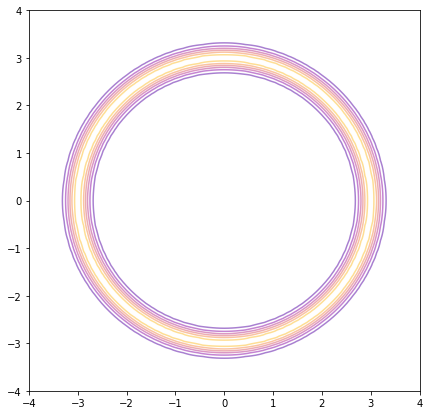

In [31]:
f, ax = plt.subplots(figsize=(7, 7))

points = np.linspace(-4, 4, 101)
x = np.tile(points, len(points))
y = np.repeat(points, len(points))

donut = DonutPDF()
z = np.exp(np.apply_along_axis(donut.log_density, 1, np.column_stack([x, y])))

ax.contour(
    points,
    points,
    z.reshape(len(points), len(points)),
    cmap="plasma",
    alpha=0.5,
)

(samps,) = ax.plot([], [], "o", alpha=0.7)
(traj,) = ax.plot([], [], "k")

